# Reinforcement Learning
# Cours 2 : Programmation dynamique

La programmation dynamique permet de résoudre des problèmes récursives en les décomposant en plus petits problèmes.
Ce TP illustre plusieurs cas d'utilisations.


1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait en groupe de 2 à 4. Aucun groupe de plus de 4 personnes. 

Vous allez rendre le TP dans une archive ZIP. L'archive ZIP contient ce notebook au format `ipynb`, mais aussi exporté en PDF & HTML. 
L'archive ZIP doit aussi contenir un fichier txt appelé `groupe.txt` sous le format:

```
Nom1, Prenom1, Email1, NumEtudiant1
Nom2, Prenom2, Email2, NumEtudiant2
Nom3, Prenom3, Email3, NumEtudiant3
Nom4, Prenom4, Email4, NumEtudiant4
```

Un script vient extraire vos réponses : ne changez pas l'ordre des cellules et soyez sûrs que les graphes sont bien présents dans la version notebook soumise. 

In [1]:
import matplotlib.pyplot as plt
import torch
import networkx as nx

## I. Chaîne de Markov finie
Un processus de décision markovien est basé sur **l'hypothèse de Markov**, qui stipule qu'en connaissant l'état à l'instant $t$, on sait tout ce qui s'est passé auparavant. 

Mathématiquement, cette hypothèse signifie que la probabilité d'une variable $X_{t+1}$ sachant l'état $ X_t $ est indépendante des états précédents :

$$
\mathbb{P}(X_{t+1}| X_{t},X_{t-1},\dots) = \mathbb{P}(X_{t+1} | X_{t})
$$

Etudions dans un premier temps plusieurs exemples de chaîne de Markov.

Ici, nous nous intéressons à la météo : $X_t$ représente le temps au jour $t$ et peut être ensoleillé, couvert ou pluvieux.

![markov](img/markov3.png)


**Q1. Ecrivez ci-dessous la valeur numérique de la matrice de transition avec PyTorch**

$$
P = \left(
\begin{array}{lll}
P_{11}, &
P_{12}, &
P_{13} \\
P_{21}, &
P_{22}, &
P_{23} \\
P_{31}, &
P_{32}, &
P_{33}
\end{array}
\right)
$$

In [2]:
P = torch.tensor([[0.5, 0.2, 0.3],
                  [0.6, 0.1, 0.3],
                  [0.2, 0.1, 0.7]])

*(aucun commentaire n'est attendu pour cette question)*

Une matrice est dite **stochastique** si elle représente une distribution de probabilité. Autrement dit, si ses lignes somment à 1 et que sont les éléments sont positifs.

**Q2. Vérifiez avec `torch` que votre matrice de transition est bien stochastique**

In [3]:
torch.equal(torch.abs(P), P) and torch.equal(torch.sum(P, 1), torch.tensor([1, 1, 1]))

True

Pour vérifier si les éléments sont positifs, on vérifie que la matrice $\mid P\mid$, soit la valeur absolue de la matrice $P$, est bien égal à la matrice $P$.  
Pour vérifier que chaque ligne est bien égale à 1, on somme les lignes et on teste que le résultat est bien 1 pour chaque ligne.  
Ces deux conditions étant vérifiées, on peut dire que la matrice est stochastique.

On simule la météo sur 2 semaines. 
Pour cela, on tire une valeur aléatoire suivant la distribution, suivante, puis les états suivants sont obtenues grâce à un tirage aléatoire utilisant la matrice de transition précédente. 

$$
\mathbb{P}(X_0 = Soleil) = 0.2$$
$$\mathbb{P}(X_0 = Couvert) = 0.3$$
$$\mathbb{P}(X_0 = Pleuvieux) = 0.5$$


**Q3. Simulez la chaîne de Markov sur 14 jours. Tracez la chaîne des états observée sur la forme d'un graph à l'aide de [`networkx`](https://stackoverflow.com/questions/51902156/plot-network-chain-in-python)**

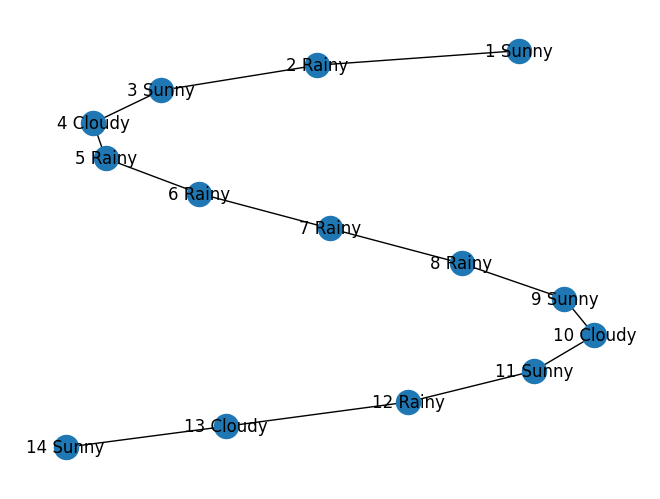

In [4]:
import random
import numpy as np

weather = ["Sunny", "Cloudy", "Rainy"]
probas = [ 0.2, 0.3, 0.5 ]

choice = random.choices(weather, weights=probas, k=1)[0]
first_weather = weather.index(choice)
state = [ 0. if i != first_weather else 1. for i in range(len(weather))]

node_label = "1 " + weather[first_weather]

G = nx.Graph()
G.add_node(node_label)
prev_node_label = node_label
for i in range(2, 15):
    # Computes the dot with the transition matrix
    probas = np.dot(state, P)
    choice = random.choices(probas, weights=probas, k=1)[0]
    
    # Get the proba for the i day
    index = np.where(probas == choice)[0][0]
    
    # Add the node to the graph
    node_label = str(i) + " " + weather[index]
    G.add_node(node_label)
    G.add_edge(prev_node_label, node_label)

    # Save the node_label (for edges) and the state
    prev_node_label = node_label
    state = [ 0. if i != index else 1. for i in range(3)]

nx.draw(G, with_labels=True)

Ce graphe réprésente la simulation de la météo sur 14 jours en ayant utilisé la matrice de transition précédente.  
On peut voir que même si le soleil a une faible probabilité d'apparaitre, sa probabilité de rester plusieurs jours de suite est élevée.  
De même, le couvert a une probabilité plus élevée de rester plusieurs jours de suite que la pluie et le soleil. C'est pourquoi la pluie est peu présente sur le graphe.

La simulation repose sur un schéma itératif. On se demande désormais si on peut exprimer une *forme analytique* (ie. une expression littérale) pour calculer la probabilité d'un futur état.

Commencons par chercher la distribution de $ X_{t+1} $ notée $ \mathbb {P} \{X_{t+1} \}$

**Q4. A l'aide des [théorèmes des probabilités](https://fr.wikipedia.org/wiki/Axiomes_des_probabilit%C3%A9s), démontrez le résultat suivant :**

$$
\mathbb {P} \{X_{t+1} = y \}
   = \sum_{x \in S} \mathbb {P} \{ X_{t+1} = y \, | \, X_t = x \}
               \cdot \mathbb {P} \{ X_t = x \}
$$

$$
\begin{align}
\sum_{x \in S} \mathbb {P} \{ X_{t+1} = y \, | \, X_t = x \}
               \cdot \mathbb {P} \{ X_t = x \}


&= \sum_{x \in S} \frac{P \{ X_{t+1} = y \} \cdot P \{ X_t = x \, | \,  X_{t+1} = y \}}{P \{ X_{t} = x \}} \cdot P \{ X_t = x \} \\



&= P \{ X_{t+1} = y \} \sum_{x \in S}  \frac{ P \{ X_t = x \}}{P \{ X_{t} = x \}} \cdot P \{ X_t = x \} \text{ car } P\{X^{}_{t+1} = y\} \text{ ne dépend pas de x} \\

&= P \{ X_{t+1} = y \} \sum_{x \in S} P \{ X_t = x \} \\

&= P \{ X_{t+1} = y \} \text{ car la somme des }  P \{ X_t = x \} \text{ avec } x \in S \text{ est égale à 1} \\ 
\end{align}
$$

Autrement dit, pour connaître la probabilité d'avoir $y$ demain, il faut considérer tous les cas aujourd'hui !
Avec la notation matricielle, cela s'écrit :

$$
\mathbb {P} \{X_{t+1} = x_j \}
   = \sum_{x_i \in S} \mathbb {P} \{ X_{t+1} = x_j | X_t = x_i \}
               \cdot \mathbb {P} \{ X_t = x_i \}
   = \sum_{i \in \{1,\dots,n\}} p_{ij} \cdot \psi_{t,i}
   = \pmb{\Psi}_{t} \cdot \pmb{P}
$$

avec $ \psi_t $ , la distribution de probabilité à l'instant $t$. 

En appliquant cette formule récursivement, on obtient la probabilité de la météo au N-ème jour à partir d'un simple calcul matriciel :

$$
\pmb{\Psi}_{t+N} = \pmb{\Psi}_{t+N-1} \cdot \pmb{P} = \cdots = \pmb{\Psi}_{t} \cdot \pmb{P}^N
$$

**Q5. Faire l'application numérique pour le 14ème jour ($\pmb{\Psi}_0$ est donné plus haut).**

In [5]:
psi_0 = np.array([ 0.2, 0.3, 0.5 ])

P_N =  np.linalg.matrix_power(P, 14)
psi_14 = np.matmul(psi_0, P_N)
psi_14

array([0.36363643, 0.13636366, 0.50000004])

Tout d'abord on calcule $P^{N}$, pour ensuite pouvoir l'utiliser dans notre calcul de $\pmb{\Psi}_{14}$

## II. Convergence vers un état stationnaire d'une chaîne de Markov.

Cette partie illustre la convergence d'une chaîne de Markov vers une **distribution stationnaire**. 

Une distribution $ \psi^\star $  est dite **stationnaire** ou **invariante** si $$\pmb{\Psi}^\star = \pmb{\Psi}^\star \cdot \pmb{P}$$

Ainsi, $$\pmb{\Psi}^\star = \pmb{\Psi}^\star \cdot\pmb{P}^k \text{ pour tout } k.$$ 

De plus, si $ X_0 $ a la distribution $ \pmb{\Psi}^\star $, alors $ X_t $ aura la même distribution pour tout $ t $.

***Théorème** : toute matrice stochastique $\pmb{P}$ admet au moins une distribution stationnaire $\pmb{\Psi}$*

**Q6. Trouvez la distribution stationnaire pour le champ de Markov précédemment défini.**

In [6]:
psi = np.array([ 0.2, 0.3, 0.5 ])
psi_prev = psi

def dist_stationnaire(psi, P, log=False):
    while (not np.equal(np.matmul(psi, P).round(decimals=6), psi).all()):
        psi = np.matmul(psi, P).round(decimals=6)
        if log:
            print(psi)
    return psi
psi_res = dist_stationnaire(psi, P, True)
print("La distribution stationnaire est:", psi_res)

tensor([0.3800, 0.1200, 0.5000], dtype=torch.float64)
tensor([0.3620, 0.1380, 0.5000], dtype=torch.float64)
tensor([0.3638, 0.1362, 0.5000], dtype=torch.float64)
tensor([0.3636, 0.1364, 0.5000], dtype=torch.float64)
tensor([0.3636, 0.1364, 0.5000], dtype=torch.float64)
tensor([0.3636, 0.1364, 0.5000], dtype=torch.float64)
La distribution stationnaire est: tensor([0.3636, 0.1364, 0.5000], dtype=torch.float64)


On effectue le calcul jusqu'à ce qu'on arrive à quelque chose de stable à 6 décimales. On observe qu'on arrive assez vite à une stabilisation.

*Théorème : si une matrice stochastique est apériodique (aucune répétition est prévisible dans la chaîne de Markov) et irréductible (on peut passer d'un état à un autre en un temps fini), alors:*

1. *la matrice stochastique admet une unique distribution stationnaire $ \psi^\star $*
1. *la chaîne de Markov converge vers cette distribution pour toute distribution initiale $ \psi_0 $ : $ \| \psi_0 P^t - \psi^\star \| \to 0 $ as $ t \to \infty $*

Une matrice satisfaisant ces conditions est dite **uniformément ergodique**.
Une condition suffisante pour cela est que tous les éléments de cette matrice  $P$ sont strictement positifs.

**Q7. Calculez plusieurs fonctions 3x3 aléatoires uniformément ergodiques et estimez leur distribution stationnaire.**

In [7]:
def generate_array_3():
    value1 = random.uniform(0., 1.)
    value2 = random.uniform(0., 1. - value1)
    return [ value1, value2, 1 - value1 - value2]

P_1 = np.array([generate_array_3() for _ in range(3)])
P_2 = np.array([generate_array_3() for _ in range(3)])
P_3 = np.array([generate_array_3() for _ in range(3)])
               
print("Premier P: ", P_1, "\nEstimation de la distribution stationnaire: ", dist_stationnaire(psi, P_1))
print("\nSecond P: ", P_2, "\nEstimation de la distribution stationnaire: ", dist_stationnaire(psi, P_2))
print("\nTroisième P:", P_3, "\nEstimation de la distribution stationnaire: ", dist_stationnaire(psi, P_3))


Premier P:  [[0.522655   0.40516062 0.07218437]
 [0.67255058 0.31934224 0.00810718]
 [0.08421198 0.87046032 0.0453277 ]] 
Estimation de la distribution stationnaire:  [0.561451 0.392759 0.045788]

Second P:  [[0.50865445 0.05344588 0.43789967]
 [0.3313696  0.31703898 0.35159142]
 [0.92240799 0.04291761 0.03467441]] 
Estimation de la distribution stationnaire:  [0.623952 0.068175 0.307873]

Troisième P: [[0.94866372 0.0457227  0.00561358]
 [0.50519785 0.00932718 0.48547497]
 [0.19168686 0.75052266 0.05779048]] 
Estimation de la distribution stationnaire:  [0.883478 0.073424 0.043096]


Tout d'abord on crée une fonction `generate_array_3` qui permet de créer les lignes de la matrices P. Cette fonction retourne un array contenant 3 valeurs entre 0 et 1 et dont leur somme est égale à 1. Cette fonction permet donc de construire une matrice $P$, qui respecte la condition suffisante pour qua la matrice soit uniformément ergodique.

On observe que la distribution stationnaire est parfois bien différente de la distribution initiale.

Ces propriétés sont fondamentales : nous allons les utiliser pour estimer la fonction de valeur optimale !

## III. La programmation dynamique dans des environnements discrets 

L'idée clé de la programmation dynamique de casser la résolution de problèmes complexes en les décomposant pour en sous-problème, passant d'un temps de résolution exponentielle à un temps polynomial.

*[Ajoutez votre commentaire ici]*

### III. 1. Estimation de la fonction de valeur d'un gridword

Nous avons vu en cours que :

$$v_\pi (s) = \mathbb{E}_\pi \left( G_t | s \right) = \sum_{s'} p(s'|s, a)\left[r+\gamma v_\pi(s') \right]$$

Dans le cas où les dynamiques de l'environnement sont entièrement connus, $p(s'|s, a)$ peut s'exprimer sous la forme d'un tensor et l'équation précédente aboutit à un système d'équations linéaires. Le problème est donc résolvable, mais la résolution risque d'être longue si l'environnement est grand. 

On cherche plutôt une résolution itérative en appliquant les principes de la programmation dynamique. Concrètement, on part d'une fonction de valeur arbitraire $v_0$ (par exemple nulle partout), puis on y applique à chaque étape l'équation de Bellman :
$$v_{k+1} (s) = \sum_{s'} p(s'|s, a)\left[r+\gamma v_k(s') \right]$$
Lorsque l'algorithme a convergé vers un point fixe $v_\infty$, nous avons fini d'évaluer $v_\pi$, puisque ce dernier est l'unique point fixe de la fonction de valeur.

Cet algorithme est appelé l'**évaluation itérative de la politique**.

On considère par la suite le "gridworld" suivant :

![gridworld](img/grid-world.png)

Les cases grisées sont terminales et la récompense est de -1 sur toutes les transitions.
La taille du gridworld est une constante `CUBE_SIDE`.

**Q8: évaluez la fonction de valeur de la politique aléatoire à l'aide d'un algorithme itératif. Arrếtez l'algorithme lorsque les valeurs n'ont pas évolué de plus de 1e-2.**

In [ ]:
from tabulate import tabulate
import typing as t
from dataclasses import dataclass, field
import random
import torch

Action = t.Literal["L", "R", "U" , "D"]
CUBE_SIDE = 6

@dataclass
class State: 
    """
    It represents any cell in the world
    """
    cell: int
    value: int = 0
    
    def __post_init__(self):
        self.bounds = {
            'L': self.cell - self.cell % CUBE_SIDE,
            'R': self.cell - self.cell % CUBE_SIDE + (CUBE_SIDE - 1),
            'U': self.cell % CUBE_SIDE,
            'D': self.cell % CUBE_SIDE + CUBE_SIDE * (CUBE_SIDE - 1),
        }
        self.neighbors = [self.act(a) for a in "LRUD"]
        assert all(i >= 0 and i < CUBE_SIDE*CUBE_SIDE for i in self.neighbors)
    
    def is_termination(self):
        return self.cell in {0, CUBE_SIDE * CUBE_SIDE - 1}

    def act(self, a: Action):
        """
        Get next state
        """
        if a == 'L': 
            return min(self.bounds['R'], max(self.bounds['L'], self.cell - 1))
        if a == 'R': 
            return min(self.bounds['R'], max(self.bounds['L'], self.cell + 1))
        if a == 'U': 
            return min(self.bounds['D'], max(self.bounds['U'], self.cell - CUBE_SIDE))
        if a == 'D':
            return min(self.bounds['D'], max(self.bounds['U'], self.cell + CUBE_SIDE))
        raise ValueError('Unexpected action')
    

def init_states():
    return [State(i) for i in range(CUBE_SIDE * CUBE_SIDE)]


@dataclass
class Env:
    states: t.List[State] = field(default_factory=init_states)

La politique gloutonne cherche uniquement à exploiter, sans aucune exploration. A chaque instant, elle choisit l'action qui permet de maximiser la fonction de valeur :

$$\pi(s) = \text{argmax}_a \sum_{s'} p(s'|s,a)[r+\gamma V(s')]$$

**Q9: calculez la politique ainsi obtenue. Vérifiez qu'il s'agit de la politique optimale. Combien d'étapes ont été nécessaires pour obtenir ce résultat ?**

*[Ajoutez votre commentaire ici]*

### III. 2. Algorithme *policy iteration*

Une amélioration de l'algorithme consiste 1) à évaluer la fonction de valeur sur un petit nombre d'itérations (on testera en Q10 avec une seule itération), puis 2) à mettre à jour la politique, puis à recommencer l'étape 1). On peut arrếter l'entraînement lorsque la politique a convergé.

**Q10: implémentez cet algorithme. Est-il plus rapide ?**

*[Ajoutez votre commentaire ici]*

### III. 4. Algorithme *value iteration*

Une autre variante conserve la politique aléatoire tout en long de l'entraînement, mais met à jour la fonction de valeur avec l'équation suivante :

$$v_{k+1} (s) = \max_{a} \sum_{s'} p(s'|s, a)\left[r+\gamma v_k(s') \right]$$

Une fois que la fonction de valeur a convergé, on calcule la politique avec :

$$\pi(s) = argmax_a \sum_{s'} p(s'|s,a)[r+\gamma V(s')]$$


**Q11: implémentez cet algorithme. Quel algorithme vous paraît le plus judicieux ?**

*[Ajoutez votre commentaire ici]*